# Planetary Boundary Layer Height Uncertainty by Gaussian Process Monte Carlo Method

In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tqdm
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import gruanpy as gp
from visual_config.color_map import map_labels_to_colors
INPUT_VARIABLES = ['time', 'alt', 'temp', 'rh', 'press', 'wspeed', 'wdir']
VARIABLES = [v for var in INPUT_VARIABLES for v in (var, var + '_uc') if var != 'time']+ ['time']

In [2]:
# data
folder = os.path.abspath(os.path.join(os.getcwd(), "..", "gdp", "products_RS41-GDP-1_LIN_2017"))
def read_folder(path=folder):
    for fname in sorted(os.listdir(path)):
        fpath = os.path.join(path, fname)
        if not os.path.isfile(fpath):
            continue
        yield gp.read(fpath)
gdps=read_folder(folder)
gdp=next(gdps)
data=gdp.data[0:1000]
data = data[VARIABLES].dropna().reset_index(drop=True)
where = gdp.global_attrs[gdp.global_attrs['Attribute'] == 'g.Site.Name']['Value'].values[0] # location
when = gdp.global_attrs[gdp.global_attrs['Attribute'] == 'g.Measurement.StartTime']['Value'].values[0] # time


In [3]:
# apply pblh methods
data = gp.parcel_method(data) # calculate PBLH using parcel method
data = gp.potential_temperature_gradient(data, virtual=True) # calculate potential temperature gradient
data = gp.RH_gradient(data) # calculate RH gradient
data = gp.specific_humidity_gradient(data) # calculate specific humidity gradient
data = gp.bulk_richardson_number_method(data) # calculate PBLH using bulk Richardson number method
pblh_pm = data['alt'][data['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in data and any(data['pblh_pm'] == 1) else None
pblh_theta = data['alt'][data['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in data and any(data['pblh_theta'] == 1) else None 
pblh_rh = data['alt'][data['pblh_rh'] == 1].iloc[0] if 'pblh_rh' in data and any(data['pblh_rh'] == 1) else None
pblh_q = data['alt'][data['pblh_q'] == 1].iloc[0] if 'pblh_q' in data and any(data['pblh_q'] == 1) else None
pblh_Ri = data['alt'][data['pblh_Ri'] == 1].iloc[0] if 'pblh_Ri' in data and any(data['pblh_Ri'] == 1) else None

In [4]:
# kernel function
def exponential_kernel(x1, x2, length_scale=100, variance=1.0):
    """Exponential kernel function."""
    dists = np.abs(x1[:, None] - x2[None, :])
    return variance * np.exp(-dists.astype(float) / length_scale)

def gp_regression(X1, y1, var1, X2, kernel_func, length_scale):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    observation variances var1, and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1, length_scale=length_scale) + np.diag(var1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, length_scale=length_scale)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, length_scale=length_scale)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

def posterior_samples(X1, y1, var1, X2, kernel_func, size=1, normalize=False, length_scale=100):
    """Draw samples from the posterior Gaussian process."""
    if normalize:
        y1_mean = np.mean(y1)
        y1_std = np.std(y1)
        y1 = (y1 - y1_mean) / y1_std
        var1 = var1 / (y1_std ** 2)
    μ2, Σ2 = gp_regression(X1, y1, var1, X2, kernel_func, length_scale)
    μ2 = μ2 * y1_std + y1_mean if normalize else μ2
    Σ2 = Σ2 * (y1_std ** 2) if normalize else Σ2
    return np.random.multivariate_normal(μ2, Σ2, size=size)

In [23]:
# Monte Carlo uncertainty estimation
M=3
noisy_profiles = []
pblh_samples = {'pm': [], 'theta': [], 'rh': [], 'q': [], 'Ri': []}
for _ in tqdm.tqdm(range(M)):
    noisy_data = data[[col for col in VARIABLES if col in data.columns]].copy(deep=True)
    for var in INPUT_VARIABLES[1:]:  # skip 'time'
        noisy_data[var] = posterior_samples(
            X1=noisy_data['time'].values,
            y1=noisy_data[var].values,
            var1=(noisy_data[var + '_uc'].values*0.5)**2,
            X2=noisy_data['time'].values,
            kernel_func=exponential_kernel,
            size=1,
            normalize=True,
            length_scale=1000000000000
        )[0]
    noisy_data = noisy_data.sort_values('alt').reset_index(drop=True)
    # Apply PBLH methods to noisy profile
    noisy_data = gp.parcel_method(noisy_data) # calculate PBLH using parcel method
    noisy_data = gp.potential_temperature_gradient(noisy_data, virtual=True) # calculate potential
    noisy_data = gp.RH_gradient(noisy_data) # calculate RH gradient
    noisy_data = gp.specific_humidity_gradient(noisy_data) # calculate specific humidity gradient
    noisy_data = gp.bulk_richardson_number_method(noisy_data) # calculate P
    noisy_profiles.append(noisy_data)
    pblh_samples['pm'].append(noisy_data['alt'][noisy_data['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in noisy_data and any(noisy_data['pblh_pm'] == 1) else None)
    pblh_samples['theta'].append(noisy_data['alt'][noisy_data['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in noisy_data and any(noisy_data['pblh_theta'] == 1) else None)
    pblh_samples['rh'].append(noisy_data['alt'][noisy_data['pblh_rh'] == 1].iloc[0] if 'pblh_rh' in noisy_data and any(noisy_data['pblh_rh'] == 1) else None)
    pblh_samples['q'].append(noisy_data['alt'][noisy_data['pblh_q'] == 1].iloc[0] if 'pblh_q' in noisy_data and any(noisy_data['pblh_q'] == 1) else None)
    pblh_samples['Ri'].append(noisy_data['alt'][noisy_data['pblh_Ri'] == 1].iloc[0] if 'pblh_Ri' in noisy_data and any(noisy_data['pblh_Ri'] == 1) else None)
# Calculate mean and std of PBLH estimates
pblh_estimates = {}
for method, samples in pblh_samples.items():
    pblh_estimates[method] = {
        'mean': np.mean(samples),
        'std': np.std(samples)
    }
# Results
print("PBLH Estimates (mean ± std):")
for method, stats in pblh_estimates.items():
    print(f"  {method}: {stats['mean']:.2f} ± {stats['std']:.2f} m")
pblh_uncertainty = {
        'pm': (np.nanmean(pblh_samples['pm']), np.nanstd(pblh_samples['pm'], ddof=1)),
        'theta': (np.nanmean(pblh_samples['theta']), np.nanstd(pblh_samples['theta'],ddof=1)),
        'rh': (np.nanmean(pblh_samples['rh']), np.nanstd(pblh_samples['rh'], ddof=1)),
        'q': (np.nanmean(pblh_samples['q']), np.nanstd(pblh_samples['q'], ddof=1)),
        'Ri': (np.nanmean(pblh_samples['Ri']), np.nanstd(pblh_samples['Ri'], ddof=1)),
    }

100%|██████████| 3/3 [00:08<00:00,  2.93s/it]

PBLH Estimates (mean ± std):
  pm: 111.45 ± 11.46 m
  theta: 2847.18 ± 327.98 m
  rh: 1273.59 ± 563.98 m
  q: 1273.59 ± 563.98 m
  Ri: 402.19 ± 3.92 m


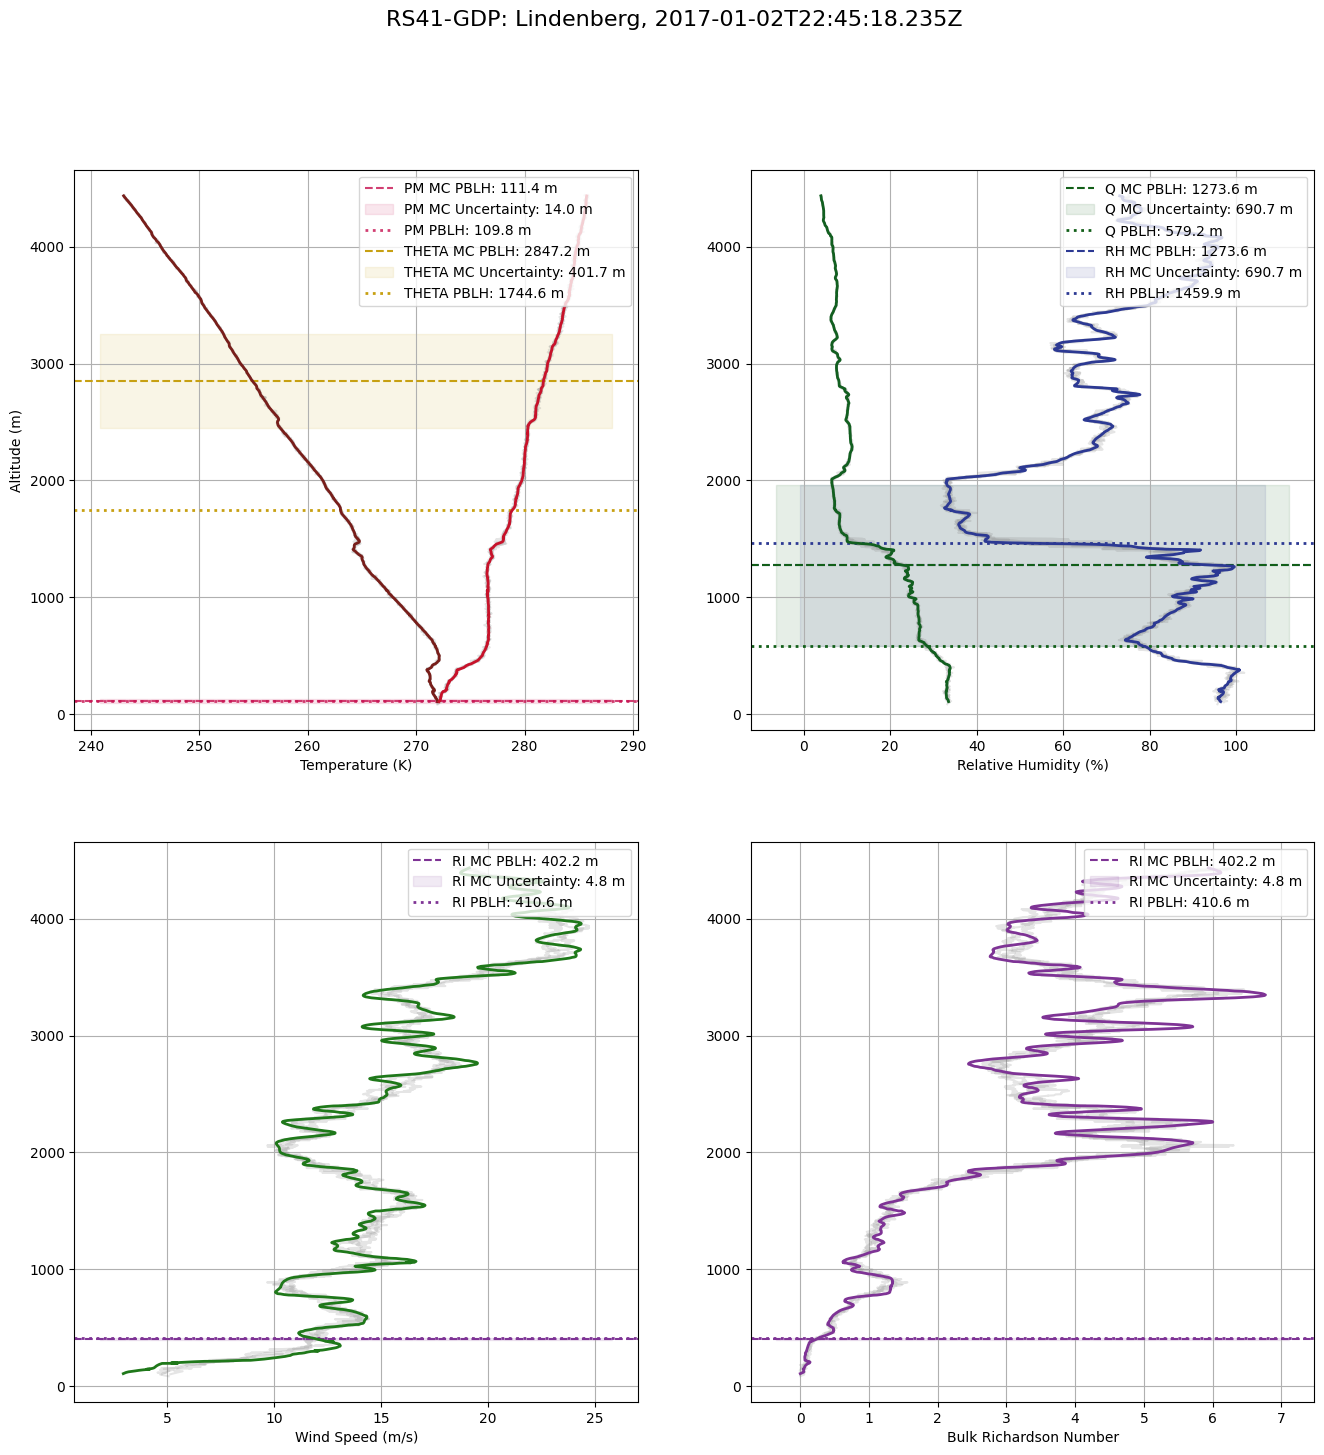

In [24]:
# plot noisy profiles with pblh estimates and uncertainties
plt.figure(figsize=(16, 16))
plt.suptitle(f'RS41-GDP: {where}, {when}'#, {file_index}'
            , fontsize=16)
# Temperature plot
ax1 = plt.subplot(2, 2, 1)
for sample in noisy_profiles: # plot all noisy profiles
    ax1.plot(sample['temp'], sample['alt'], color='gray', alpha=0.2)
    ax1.plot(sample['virtual_theta'], sample['alt'], color='gray', alpha=0.2)
ax1.plot(data['temp'], data['alt'], #label='True Temperature',
            color=map_labels_to_colors['temp'], linewidth=2, zorder=5) # plot true temperature
ax1.plot(data['virtual_theta'], data['alt'], #label='True Virtual Potential Temperature', 
        color=map_labels_to_colors['virtual_theta'], linewidth=2, zorder=5) # plot true virtual potential temperature
if pblh_pm is not None: # plot PBLH line
    ax1.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle=':', linewidth=2, label=f'PM PBLH: {pblh_pm:.1f} m')
if pblh_theta is not None: # plot PBLH line
    ax1.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle=':', linewidth=2, label=f'THETA PBLH: {pblh_theta:.1f} m')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (m)')
ax1.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax1.get_xlim()[0],ax1.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    temperature_methods=['pm', 'theta']
    if mean is not None and label in temperature_methods:
        ax1.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax1.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.1,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# RH plot
ax2 = plt.subplot(2, 2, 2)
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['rh'], sample['alt'], color='gray', alpha=0.2)
ax2.plot(data['rh'], data['alt'], #label='True RH', 
            color=map_labels_to_colors['rh'], linewidth=2, zorder=5) # plot true RH
ax2.plot(data['q']*10000, data['alt'], #label='True Specific Humidity', 
                color=map_labels_to_colors['q'], linewidth=2, zorder=5) # plot true specific humidity
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['q']*10000, sample['alt'], color='gray', alpha=0.2)
if pblh_rh is not None: # plot PBLH line
    ax2.axhline(pblh_rh, color=map_labels_to_colors['pblh_rh'], linestyle=':', linewidth=2, label=f'RH PBLH: {pblh_rh:.1f} m')
if pblh_q is not None:
    ax2.axhline(pblh_q, color=map_labels_to_colors['pblh_q'], linestyle=':', linewidth=2, label=f'Q PBLH: {pblh_q:.1f} m')
ax2.set_xlabel('Relative Humidity (%)')
#ax2.set_ylabel('Altitude (m)')
ax2.grid()
# Add PBLH lines and uncertainty bands
for label, (mean, std) in pblh_uncertainty.items():
    humidity_methods=['rh', 'q']
    if mean is not None and label in humidity_methods:
        ax2.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax2.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=ax2.get_xlim()[0],
            x2=ax2.get_xlim()[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.1,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# wind speed plot
ax3 = plt.subplot(2, 2, 3)
for sample in noisy_profiles: # plot all noisy profiles
    ax3.plot(sample['wspeed'], sample['alt'], color='gray', alpha=0.2)
ax3.plot(data['wspeed'], data['alt'], #label='True Wind Speed', 
            color=map_labels_to_colors['wspeed'], linewidth=2, zorder=5) # plot true wind speed
if pblh_Ri is not None: # plot PBLH line
    ax3.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle=':', linewidth=2, label=f'RI PBLH: {pblh_Ri:.1f} m')
ax3.set_xlabel('Wind Speed (m/s)')
#ax3.set_ylabel('Altitude (m)')
ax3.grid()
# Add PBLH lines and uncertainty bands
for label, (mean, std) in pblh_uncertainty.items():
    if mean is not None and label in ['Ri']:
        ax3.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax3.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=ax3.get_xlim()[0],
            x2=ax3.get_xlim()[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.1,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')


#plot Ri profile
ax6 = plt.subplot(2, 2, 4)
for sample in noisy_profiles: # plot all noisy profiles
    ax6.plot(sample['Ri_b'], sample['alt'], color='gray', alpha=0.2)
ax6.plot(data['Ri_b'], data['alt'], #label='Bulk Richardson Number', 
            color=map_labels_to_colors['Ri_b'], linewidth=2, zorder=5) # plot Ri profile
if pblh_Ri is not None: # plot PBLH line
    ax6.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle=':', linewidth=2, label=f'RI PBLH: {pblh_Ri:.1f} m')
ax6.set_xlabel('Bulk Richardson Number')
#ax6.set_ylabel('Altitude (m)')
ax6.grid()
# Add PBLH lines and uncertainty bands
for label, (mean, std) in pblh_uncertainty.items():
    if mean is not None and label in ['Ri']:
        ax6.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax6.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=ax6.get_xlim()[0],
            x2=ax6.get_xlim()[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.1,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

plt.show()


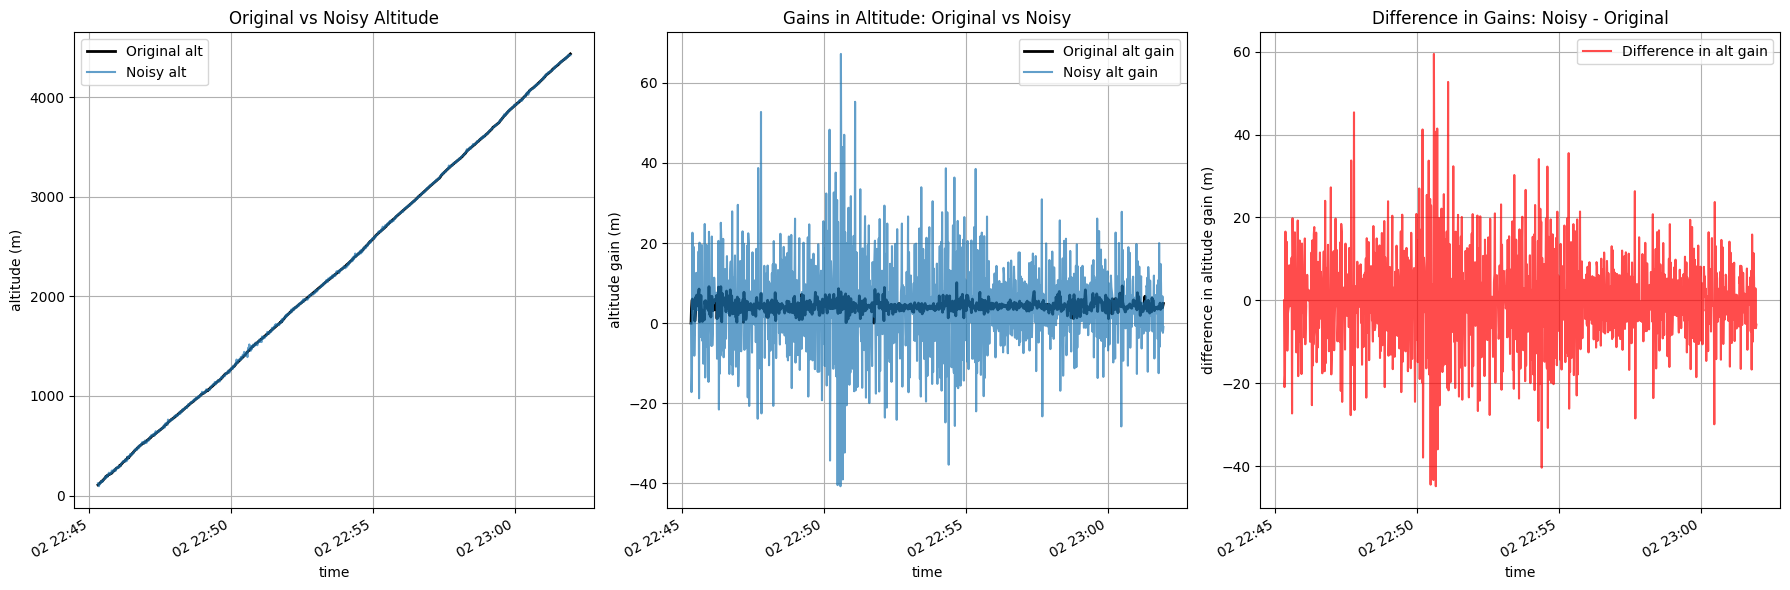

In [38]:
# the altitude problem
noisy_data = data[[col for col in VARIABLES if col in data.columns]].copy(deep=True)
noisy_data['alt'] = posterior_samples(
    X1=noisy_data['time'].values,
    y1=noisy_data['alt'].values,
    var1=(noisy_data['alt_uc'].values*0.5)**2,
    X2=noisy_data['time'].values,
    kernel_func=exponential_kernel,
    size=1,
    normalize=True,
    length_scale=1000)[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Plot 1: Original vs Noisy Altitude
axes[0].plot(data['time'], data['alt'], label='Original alt', color='black', linewidth=2)
axes[0].plot(noisy_data['time'], noisy_data['alt'], label='Noisy alt', alpha=0.7)
axes[0].set_xlabel('time')
axes[0].set_ylabel('altitude (m)')
axes[0].set_title('Original vs Noisy Altitude')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gains in Altitude
gain_alt = data['alt'].diff().fillna(0)
gain_noisy_alt = noisy_data['alt'].diff().fillna(0)
axes[1].plot(data['time'], gain_alt, label='Original alt gain', color='black', linewidth=2)
axes[1].plot(noisy_data['time'], gain_noisy_alt, label='Noisy alt gain', alpha=0.7)
axes[1].set_xlabel('time')
axes[1].set_ylabel('altitude gain (m)')
axes[1].set_title('Gains in Altitude: Original vs Noisy')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Difference in Gains
diff_gain = gain_noisy_alt - gain_alt
axes[2].plot(data['time'], diff_gain, label='Difference in alt gain', color='red', alpha=0.7)
axes[2].set_xlabel('time')
axes[2].set_ylabel('difference in altitude gain (m)')
axes[2].set_title('Difference in Gains: Noisy - Original')
axes[2].legend()
axes[2].grid(True)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

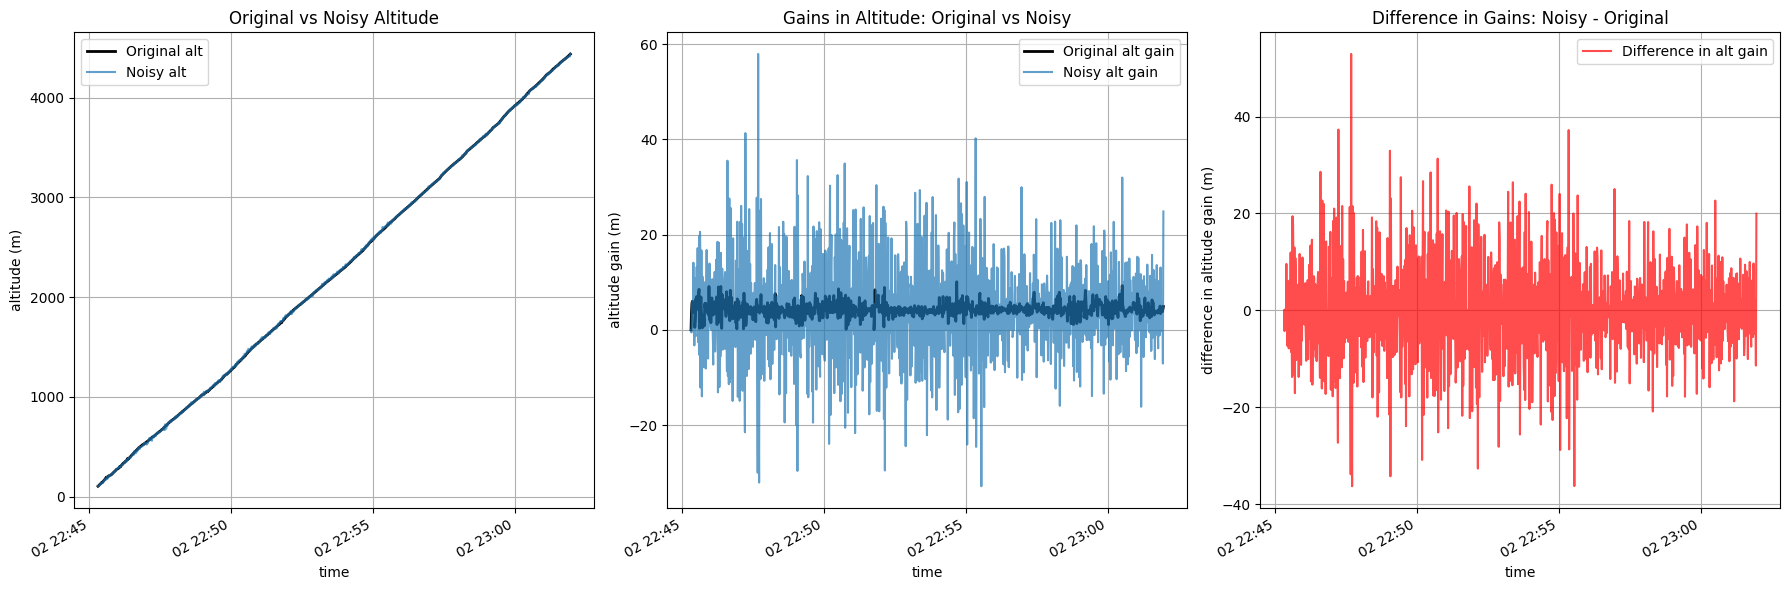

In [39]:
# the altitude problem
linear_trend = np.polyfit(data['time'].values.astype(float), data['alt'].values, 1)
data['alt_detrended'] = data['alt'] - (linear_trend[0] * data['time'].values.astype(float) + linear_trend[1])
extended_VARS = VARIABLES + ['alt_detrended']
noisy_data = data[[col for col in extended_VARS if col in data.columns]].copy(deep=True)
noisy_data['alt_detrended'] = posterior_samples(
    X1=noisy_data['time'].values,
    y1=noisy_data['alt_detrended'].values,
    var1=(noisy_data['alt_uc'].values*0.5)**2,
    X2=noisy_data['time'].values,
    kernel_func=exponential_kernel,
    size=1,
    normalize=True,
    length_scale=1000)[0]
noisy_data['alt'] = noisy_data['alt_detrended'] + (linear_trend[0] * noisy_data['time'].values.astype(float) + linear_trend[1])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Plot 1: Original vs Noisy Altitude
axes[0].plot(data['time'], data['alt'], label='Original alt', color='black', linewidth=2)
axes[0].plot(noisy_data['time'], noisy_data['alt'], label='Noisy alt', alpha=0.7)
axes[0].set_xlabel('time')
axes[0].set_ylabel('altitude (m)')
axes[0].set_title('Original vs Noisy Altitude')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gains in Altitude
gain_alt = data['alt'].diff().fillna(0)
gain_noisy_alt = noisy_data['alt'].diff().fillna(0)
axes[1].plot(data['time'], gain_alt, label='Original alt gain', color='black', linewidth=2)
axes[1].plot(noisy_data['time'], gain_noisy_alt, label='Noisy alt gain', alpha=0.7)
axes[1].set_xlabel('time')
axes[1].set_ylabel('altitude gain (m)')
axes[1].set_title('Gains in Altitude: Original vs Noisy')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Difference in Gains
diff_gain = gain_noisy_alt - gain_alt
axes[2].plot(data['time'], diff_gain, label='Difference in alt gain', color='red', alpha=0.7)
axes[2].set_xlabel('time')
axes[2].set_ylabel('difference in altitude gain (m)')
axes[2].set_title('Difference in Gains: Noisy - Original')
axes[2].legend()
axes[2].grid(True)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()